# Ocean iron concentration

---

## Overview
Iron is one of the most important micronutrients in the ocean, limiting production in some areas. In this notebook, we make a map of iron concentration and compare to observational data.

1. Gemeral setup
2. Subsetting
3. Processing data
4. Comparing to observational data
   
TO DO: Add more narrative text, clean up comments, clarify how Fe obs are compiled exactly

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Dask Cookbook](https://projectpythia.org/dask-cookbook/README.html) | Helpful | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Helpful | |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |

- **Time to learn**: 15 min


---

## Imports

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from dask.distributed import LocalCluster
import pandas as pd

## General setup (see intro notebooks for explanations)

### Connect to cluster

In [2]:
cluster = LocalCluster()
client = cluster.get_client()

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46127 instead
  warnings.warn(


### Bring in POP grid utilities

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Load the data

In [5]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
path

'/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

In [6]:
files = glob.glob(f'{path}/{case}.pop.h.*.195801-202112.nc')
ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, decode_times=True)
ds

<xarray.Dataset> Size: 182GB
Dimensions:                         (nlat: 384, nlon: 320, time: 768, z_t: 60,
                                     z_w: 60, lat_aux_grid: 395, moc_comp: 3,
                                     moc_z: 61, d2: 2, transport_comp: 5,
                                     transport_reg: 2, z_t_150m: 15,
                                     z_w_bot: 60, z_w_top: 60)
Coordinates:
    TLAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lat_aux_grid                    (lat_aux_grid) float32 2kB -79.49 ... 90.0
  * moc_z                           (moc_z) float32 244B 0.0 1e+03 ... 5.5e+05
  * time                            (time) object 6kB 1958-02-01 00:00:00 ......
  * z_t                             (z_t) float32 240B 500.0 ... 5.375e+05
  * z_t_150m                        (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                             (z_w) float32 240B 0.0 1e+03 ... 5.25e+05
  * z_w_bot                         (z_w_bot) float32 240B 1e+03 ... 5.5e+05
  * z_w_top                         (z_w_top) float32 240B 0.0 ... 5.25e+05
Dimensions without coordinates: nlat, nlon, moc_comp, d2, transport_comp,
                                transport_reg
Data variables: (12/99)
    ANGLE                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ANGLET                          (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXT                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXU                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYT                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYU                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                              ...
    sp_Fe_lim_Cweight_avg_100m      (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_Fe_lim_surf                  (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_N_lim_Cweight_avg_100m       (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_N_lim_surf                   (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_P_lim_Cweight_avg_100m       (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_P_lim_surf                   (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
Attributes:
    title:             g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch
    history:           Wed Jun 21 08:37:09 2023: ncks -O -4 -L 1 /glade/scrat...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-06-13 at 16:35:05.0
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.4 (Homepage = http://nco....

## Subsetting

In [7]:
variables =['Fe']

In [8]:
keep_vars=['z_t','z_t_150m','dz','time_bound', 'time','TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

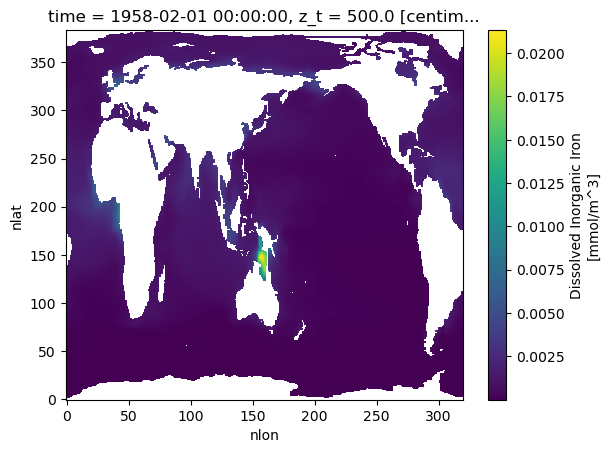

In [9]:
ds.Fe.isel(time=0,z_t=0).plot()

## Transforming from monthly to annual data

Pull in the function we defined in the nutrients notebook...

In [10]:
def year_mean(ds):
    """
    Properly convert monthly data to annual means, taking into account month lengths.
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")
    

Take the long-term mean of our data set. We process monthly to annual with our custom function, then use xarray's built-in `.mean()` function to process from annual data to a single mean over time, since each year is the same length.

In [11]:
ds = year_mean(ds).mean("year")

In [12]:
nmolcm3_to_nM = 1.e3
ds['Fe'] = ds['Fe'] * nmolcm3_to_nM
ds['Fe'].attrs['units'] = 'nM'

## Compare to observational Fe database

Observations compiled from:
- [Schlitzer et al., 2018](https://www.sciencedirect.com/science/article/pii/S0009254118302961?pes=vor)
- [Moore and Braucher, 2008](https://bg.copernicus.org/articles/5/631/2008/)
- [Tagliabue et al., 2012](https://bg.copernicus.org/articles/9/2333/2012/)

as collected by [Long et al., 2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021MS002647)

In [13]:
dFe_obs_file = '/glade/u/home/kristenk/cesm2-marbl/notebooks/discrete_obs/dFe-database-2021-05-20.csv'
df = pd.read_csv(dFe_obs_file, na_values=-999.).dropna(axis=0, how='all')

df

,lon,lat,depth,dFe_obs
0,210.010,-16.0018,20.0,0.540000
1,210.010,-16.0018,35.0,0.440000
2,210.010,-16.0019,50.0,0.480000
3,210.010,-16.0019,80.0,0.400000
4,210.010,-16.0020,100.0,0.390000
...,...,...,...,...
27777,160.051,47.0032,3929.6,0.825681
27778,160.051,47.0032,3929.8,0.902248
27779,160.051,47.0032,4900.4,0.555630
27780,160.051,47.0032,4900.9,0.621851


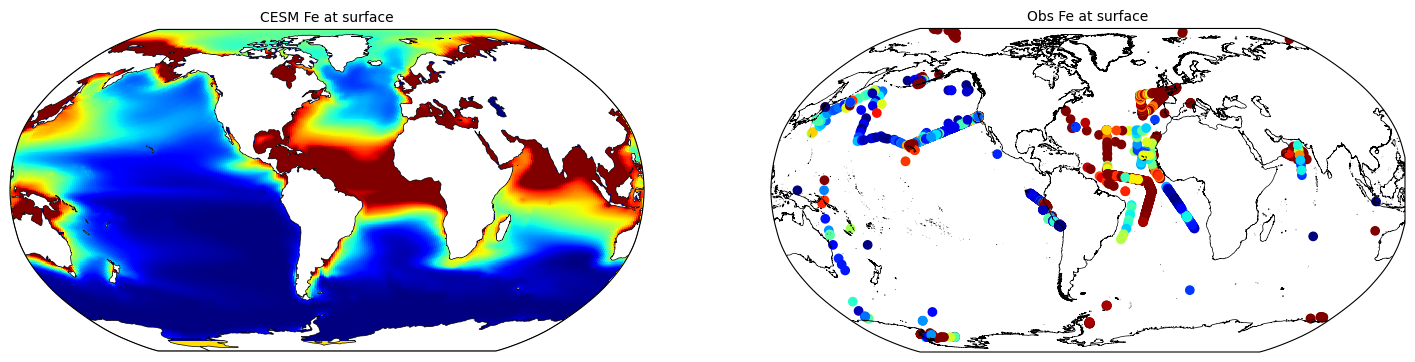

In [14]:
fig = plt.figure(figsize=(18,7))

##### top 100m

### CESM
ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats,  ds.Fe.isel(z_t=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0.05,vmax=1.6,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('CESM Fe at surface', fontsize=10)


### obs
ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Obs Fe at surface', fontsize=10)


df_sub = df.loc[(df.depth <= 2.5)]
sc = ax.scatter(df_sub.lon, df_sub.lat, c=df_sub.dFe_obs.values,
                cmap='jet',
                vmin=0.05, vmax=0.6, 
                transform=ccrs.PlateCarree())



And close the Dask cluster we spun up at the beginning.

In [15]:
cluster.close()

---

## Summary
You've learned how to make a map of ocean iron and compare it to observations.

## Resources and references
- [Schlitzer et al., 2018](https://www.sciencedirect.com/science/article/pii/S0009254118302961?pes=vor)
- [Moore and Braucher, 2008](https://bg.copernicus.org/articles/5/631/2008/)
- [Tagliabue et al., 2012](https://bg.copernicus.org/articles/9/2333/2012/)